# 모듈 불러오기

In [1]:
# !conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os 
import glob
import itertools
from copy import deepcopy
from sklearn.model_selection import KFold

import datetime

from dataloader import *

from model_distribution import *

# Train

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

learning_rate = 0.001
n_epochs = 2000

criterion_distribution = nn.GaussianNLLLoss()

In [4]:
# 경로 입력 및 아이디 추출

file_path = "./data/total/"
data_path = glob.glob(file_path + '*')
name = []
for file_name in data_path:
    folder_name = os.path.split(file_name)[1][:7]
    name += [folder_name]
    
id_name = np.unique(name)

In [5]:
id_name

array(['IF00017', 'IF00024', 'IF00034', 'IF00041', 'IF01020', 'IF01045',
       'IF01047', 'IF02035', 'IF03014', 'IF03027', 'IF03039', 'IF94031',
       'IF99008', 'IF99013', 'IF99030', 'IF99032', 'IM01006', 'IM01029',
       'IM02040', 'IM03011', 'IM03048', 'IM96018', 'IM96033', 'IM97015',
       'IM98009', 'IM98019', 'IM98026', 'IM98036', 'IM98042', 'IM98049',
       'IM98050', 'IM99007', 'IM99010', 'IM99012', 'IM99021', 'IM99025',
       'IM99037'], dtype='<U7')

In [6]:
test_id = np.array(['IF03014', 'IF00041', 'IM02040', 'IM98049'])
# test_id = np.array(['IF03014', 'IF00041', 'IM02040', 'IM98042'])

In [7]:
# seed 고정
random_seed = 77
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random


kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

id_name_trnval = np.setdiff1d(id_name, test_id)
best_MAE_fold = 0
for fold, (train_idx, valid_idx) in enumerate(kfold.split(id_name_trnval)):
    train_id = id_name_trnval[train_idx]
    valid_id = id_name_trnval[valid_idx]

    print('Train ID : {}\n Valid ID {}'.format(train_id, valid_id))
    
    train_dataset_R = Gait_Dataset_Salted(file_path, train_id, right=True)
    train_dataset_L = Gait_Dataset_Salted(file_path, train_id, right=False)

    valid_dataset_R = Gait_Dataset_Salted(file_path, valid_id, right=True)
    valid_dataset_L = Gait_Dataset_Salted(file_path, valid_id, right=False)

    train_dataset = torch.utils.data.ConcatDataset([train_dataset_R, train_dataset_L])
    valid_dataset = torch.utils.data.ConcatDataset([valid_dataset_R, valid_dataset_L])
    
    print(len(train_dataset), len(valid_dataset))
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=len(train_dataset),
                                           shuffle=True,
                                           worker_init_fn=np.random.seed(42))
    val_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=len(valid_dataset),
                                             shuffle=False)


    print('Fold {} Dataloader Load Complete'.format(fold+1))



    model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early Stopping을 위한 변수
    best = 10000
    converge_cnt = 0
    best_MAE = 1000
    best_corr = 0
    best_epoch = 0

        # 학습 시작 시간 기록
    start_time = datetime.datetime.now()
    print(f"Training started at: {start_time}")
    
    # Run Training loop
    for epoch in range(0, n_epochs):
        # Set current loss value 
        tot_trn_loss = 0.0
    
        # Train Mode
        model.train()
    
        # Iterate over the DataLoader for training data 
        for i, data in enumerate(train_loader):
            inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
            inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float(), mu.float(), sigma.float() 
            inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)
    
            mu, sigma = mu.reshape(-1, 1), sigma.reshape(-1, 1)
            mu, sigma = mu.to(device), sigma.to(device)
    
            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)
    
            # 순전파 
            outputs, var = model(inputs_acc, inputs_gyr, inputs_prs)
    
            # Loss 계산
            loss = criterion_distribution(mu, outputs, var)
    
            # 기울기 초기화 
            optimizer.zero_grad()
            # 역전파
            loss.backward()
            # 옵티마이저
            optimizer.step()
    
            # Print statistics
            tot_trn_loss += loss.item()
    
        # Evaluation Mode
        model.eval()
    
        tot_val_loss = 0
        tot_val_MAE = 0
        val_epoch_loss = []
    
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
                inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float(), mu.float(), sigma.float() 
                inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)
    
                mu, sigma = mu.reshape(-1, 1), sigma.reshape(-1, 1)
                mu, sigma = mu.to(device), sigma.to(device)
    
                stride_length = stride_length.reshape(-1, 1)
                stride_length = stride_length.to(device)
    
                # 순전파 
                outputs, var = model(inputs_acc, inputs_gyr, inputs_prs)
    
                # Loss 계산
                loss = criterion_distribution(mu, outputs, var)
    
                tot_val_loss += loss.item()
                tot_val_MAE += torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)
    
        # Epoch 별 Loss
        trn_loss = tot_trn_loss / len(train_loader)
        val_loss = tot_val_loss / len(val_loader)
        MAE = tot_val_MAE / len(val_loader)    
    
        # print("Fold : {}, Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}".format(fold+1, epoch+1, n_epochs,
        #                                                                                        trn_loss, val_loss, MAE))
    
        # Early Stopping
        if val_loss < best:
            best = np.mean(val_loss)
            best_MAE = MAE
            best_epoch = epoch+1
            torch.save(deepcopy(model.state_dict()), './model/L2/L2_fold{}.pth'.format(fold+1))
            # print('Best Valid Loss {:.4f}'.format(best))
            converge_cnt = 0
        else:
            converge_cnt += 1
    
        if converge_cnt > 50:
            print('Early stopping')
            print('Best Result : Fold : {}, Epoch {}, Valid Loss {:.3f}, MAE {:.3f}'.format(fold+1, best_epoch, best, best_MAE))
            best_MAE_fold += best_MAE
            break
    
    # 학습 종료 시간 및 경과 시간 계산
    end_time = datetime.datetime.now()
    elapsed_time = end_time - start_time
    print(f"Training ended at: {end_time}")
    print(f"Total training time: {elapsed_time}")




Train ID : ['IF00017' 'IF00024' 'IF01020' 'IF01045' 'IF01047' 'IF02035' 'IF03027'
 'IF99008' 'IF99013' 'IF99030' 'IF99032' 'IM01006' 'IM01029' 'IM03011'
 'IM03048' 'IM96018' 'IM96033' 'IM97015' 'IM98009' 'IM98026' 'IM98036'
 'IM98042' 'IM98050' 'IM99007' 'IM99010' 'IM99012' 'IM99021' 'IM99025'
 'IM99037']
 Valid ID ['IF00034' 'IF03039' 'IF94031' 'IM98019']
1106 181
Fold 1 Dataloader Load Complete
Training started at: 2024-11-04 15:30:23.088602
Early stopping
Best Result : Fold : 1, Epoch 36, Valid Loss 3.441, MAE 10.458
Training ended at: 2024-11-04 15:31:18.253725
Total training time: 0:00:55.165123
Train ID : ['IF00017' 'IF00024' 'IF00034' 'IF01020' 'IF01045' 'IF01047' 'IF02035'
 'IF03027' 'IF03039' 'IF94031' 'IF99008' 'IF99013' 'IF99030' 'IM01006'
 'IM01029' 'IM03011' 'IM03048' 'IM96033' 'IM97015' 'IM98009' 'IM98019'
 'IM98026' 'IM98036' 'IM98042' 'IM98050' 'IM99010' 'IM99021' 'IM99025'
 'IM99037']
 Valid ID ['IF99032' 'IM96018' 'IM99007' 'IM99012']
1153 134
Fold 2 Dataloader Load C

KeyboardInterrupt: 

# Visualize

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

test_file_path = "./data/total/"

test_dataset_R = Gait_Dataset_Salted(test_file_path, test_id, right=True)
test_dataset_L = Gait_Dataset_Salted(test_file_path, test_id, right=False)

test_dataset = torch.utils.data.ConcatDataset([test_dataset_R, test_dataset_L])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                       batch_size=len(test_dataset),
                                       shuffle=False,
                                       worker_init_fn=np.random.seed(42))

Training started at: 2024-11-04 16:21:49.049782
./model/L2/L2_fold8.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold7.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold9.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold5.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold1.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold3.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold10.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold2.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold4.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


./model/L2/L2_fold6.pth


/tmp/ipykernel_33214/2570022254.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


MAE : 6.0632, MAPE : 95.61%, RMSE : 7.7091, RSE : 0.1186


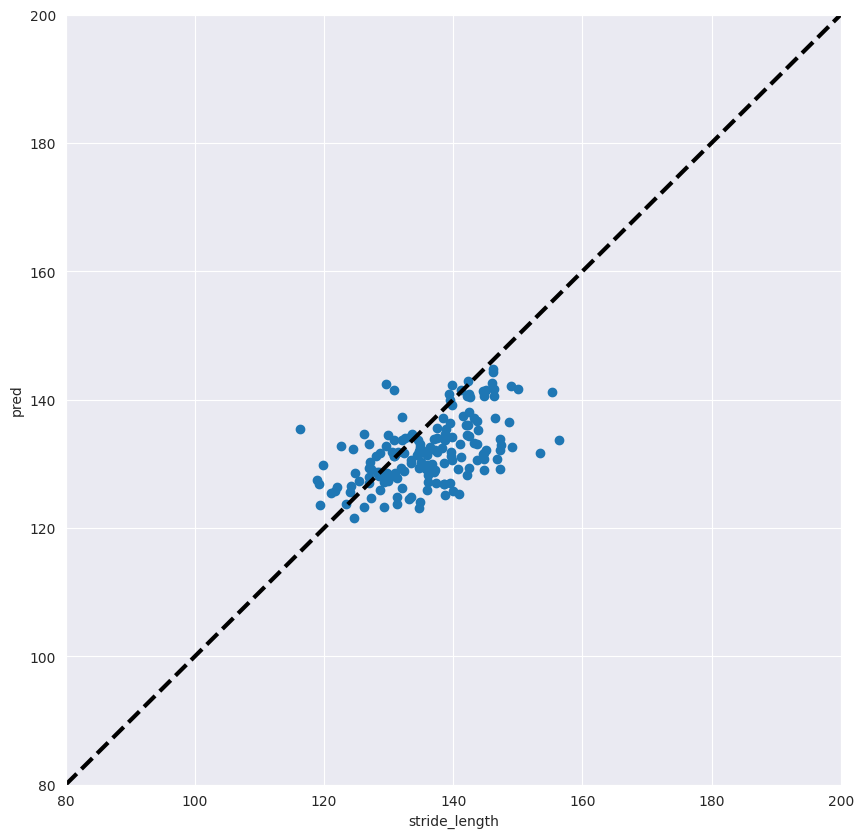

Training ended at: 2024-11-04 16:21:53.430135
Total training time: 0:00:04.380353


In [11]:
### Scatter Plot 

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

stride_length_list = pd.DataFrame()
sigma_list = pd.DataFrame()
tot_val_MAE = 0
tot_val_MAPE = 0

start_time = datetime.datetime.now()
print(f"Training started at: {start_time}")

for fold_idx, model_name in enumerate(glob.glob('./model/L2/L2_fold' + '*')):
    print(model_name)
    model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim)
    model.load_state_dict(torch.load(model_name))
    model.eval()
    pred_list = []
    for i, data in enumerate(test_loader):
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc, inputs_gyr, inputs_prs

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length

        outputs = model(inputs_acc, inputs_gyr, inputs_prs)
        stride_length_list.loc[:, fold_idx] = outputs[0].reshape(-1).cpu().detach().numpy()
        sigma_list.loc[:, fold_idx] = outputs[1].reshape(-1).cpu().detach().numpy()
        
pred = stride_length_list.mean(axis=1)
stride_length = stride_length.reshape(-1).cpu().detach().numpy()
# stride_length = stride_length.reshape(-1)

mu = mu.cpu().detach().numpy()
# mu = mu

# print(pred)
# print(stride_length_list)
MAE = np.sum(np.abs(pred - stride_length)) / len(stride_length)
MAPE = 100 - (np.mean(np.abs(pred - stride_length) / stride_length) * 100)
RMSE = np.sqrt(np.mean((stride_length - pred)**2))
RSE = RMSE / np.sqrt(np.sum((stride_length - mu)**2))


print('MAE : {:.4f}, MAPE : {:.2f}%, RMSE : {:.4f}, RSE : {:.4f}'.format(MAE, MAPE, RMSE, RSE))
# print('MAE : {:.4f}'.format(MAE))

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

end_time = datetime.datetime.now()
elapsed_time = end_time - start_time
print(f"Training ended at: {end_time}")
print(f"Total training time: {elapsed_time}")